In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pystan

In [3]:
# Setup for a GMM 
code = '''

data {
    int<lower=1> K;
    int<lower=1> N;
    real y[N];
}

parameters {
    simplex[K] theta;
    ordered[K] mu;
    vector<lower=0>[K] sigma;
}

transformed parameters {
    vector[K] log_theta = log(theta);
}

model {
    sigma ~ lognormal(0, 2);
    mu ~ normal(0, 10);
    for (n in 1:N) {
        vector[K] lps = log_theta;
        for (k in 1:K) lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
        target += log_sum_exp(lps);
    }
}

'''

gmm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8a07233cb4d20806a4cfc6164516c4d8 NOW.


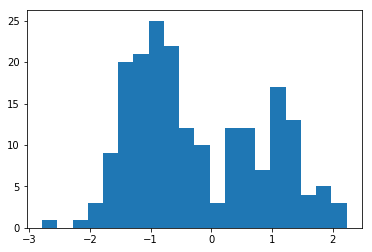

Inference for Stan model: anon_model_8a07233cb4d20806a4cfc6164516c4d8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]       0.62  1.9e-3   0.05   0.52   0.59   0.62   0.65    0.7    617    1.0
theta[1]       0.38  1.9e-3   0.05    0.3   0.35   0.38   0.41   0.48    617    1.0
mu[0]         -0.96  1.2e-3   0.06  -1.07   -1.0  -0.96  -0.92  -0.84   2314    1.0
mu[1]          0.96  5.4e-3   0.11   0.73    0.9   0.97   1.03   1.13    431   1.01
sigma[0]        0.5  1.4e-3   0.05   0.42   0.47    0.5   0.53    0.6   1154    1.0
sigma[1]       0.56  4.1e-3   0.09   0.44   0.51   0.55    0.6   0.76    449   1.01
log_theta[0]  -0.49  3.6e-3   0.08  -0.65  -0.53  -0.48  -0.44  -0.35    489   1.01
log_theta[1]  -0.96  4.2e-3   0.12  -1.21  -1.04  -0.96  -0.89  -0.74    811    1.0
lp__         -271.1    0.07   1.78 -275.6 -271.9 -270.7

In [5]:
# GMM experiments
# Just making sure I understand how the mixture model framework works

N = 200
K = 2
theta = np.array([.6, .4])
c = np.random.choice(2, size=N, p=theta)
mu = np.array([-1, 1])
sigma = np.array([.5, .5])

y  = mu[c] + sigma[c] * np.random.randn(N)
plt.hist(y, bins=20); plt.show()

samps = gmm.sampling(data=dict(N=N, K=K, y=y))
samps

In [66]:
def plot_sigmas(samps):
    sigma_ = samps.extract()['sigma']
    plt.scatter(sigma_[:, 0], sigma_[:, 1], alpha=.5)
    plt.xlim(0, sigma_.max() * 1.1)
    plt.ylim(0, sigma_.max() * 1.1)
    plt.title('Sigma')
    plt.xlabel('Signal Class')
    plt.ylabel('Noise Class')
    return

def plot_thetas(samps):
    x = samps.data['x']
    y = samps.data['y']
    f = samps.extract()['f'].mean(0)
    theta_ = samps.extract()['theta'][:, :, 0]
    plt.title('Posterior Mean & Class')
    plt.scatter(x, y, c=theta_.mean(0), cmap='RdBu', vmin=0, vmax=1)
    plt.colorbar()
    plt.plot(x, f)
    return

In [35]:
# Set up for mixture of GPs

code = '''

data {
    int<lower=1> K;
    int<lower=1> N;
    real x[N];
    vector[N] y;
}

transformed data {
    real delta = 1e-9;
}

parameters {

    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N] eta;
    
    simplex[K] theta[N];
    positive_ordered[K] sigma;
}


transformed parameters {
    vector[N] f;
    {
        matrix[N, N] L_K;
        matrix[N, N] krn = cov_exp_quad(x, alpha, rho);
        for (n in 1:N) krn[n, n] += delta;
        L_K = cholesky_decompose(krn);
        f = L_K * eta;
    }
}

model {
    rho ~ inv_gamma(5, 5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    
    sigma ~ lognormal(0, 2);
    for (n in 1:N) {
        vector[K] lps = log(theta[n]);
        for (k in 1:K) lps[k] += normal_lpdf(y[n] | f[n], sigma[k]);
        target += log_sum_exp(lps);
    }
}

'''

gpmm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c20e7982983cdce93c6e101a32022358 NOW.


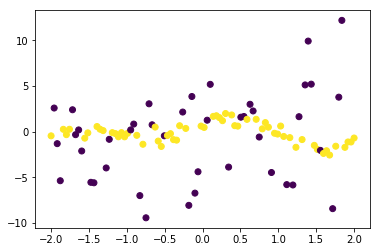

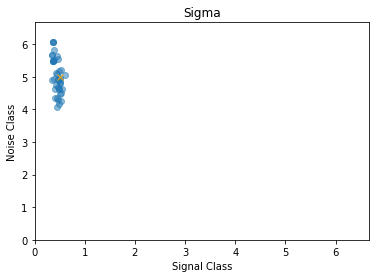

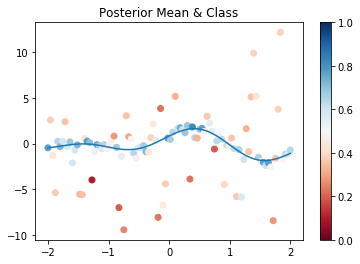

In [83]:
# GPMixture experiments

# Scatter noise class throughout data

def true_f(x):
    return np.sin(3*x) + np.cos(2*x)

K = 2
N = 100
theta = np.array([.4, .6])
sigma = np.array([5, .5])
c = np.random.choice(2, size=N, p=theta)


x = np.linspace(-2, 2, N)
y = true_f(x) + np.random.randn(N) * sigma[c]
plt.scatter(x, y, c=c)
plt.show()

samps = gpmm.sampling(data=dict(K=K, N=N, x=x, y=y), iter=20)

plot_sigmas(samps)
plt.plot([sigma[1]], [sigma[0]], marker='x', color='orange')
plt.show()
plot_thetas(samps)

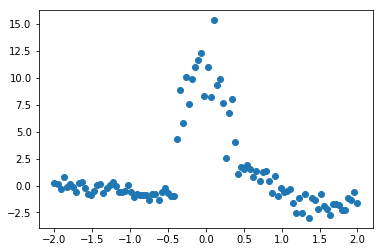

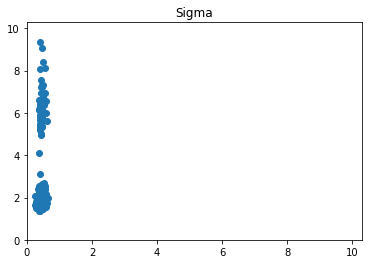

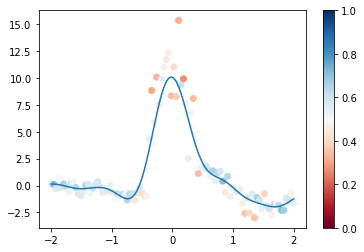

In [46]:
# Very rough reproduction of Fig 5 from HR paper
# add noise to one section of the data

K = 2
N = 100
sigma = .5

x = np.linspace(-2, 2, N)
y = true_f(x) + np.random.randn(N) * sigma
noise_idx = np.arange(N//2 - N//10, N//2 + N//10)
y[noise_idx] = 8 + 3 * np.random.randn(noise_idx.size)
plt.scatter(x, y)
plt.show()

samps = gpmm.sampling(data=dict(K=K, N=N, x=x, y=y), iter=200)
sigma_ = samps.extract()['sigma']
theta_ = samps.extract()['theta'][:, :, 0]

plot_routine(x, y, sigma_, theta_)

The model in the paper seems to ignore the noise around 0.
What are they doing that allows for this?
Some differences between mine and theirs:
    They have a much more advanced kernel to explain what they expect to see
    They give the mixing coefficients
    They 


I am not sure why the class membership in the second model is so conservative.
    Prior on sigma?
    No prior on theta?

How are GPs used for prediction?
    Do I try to learn the parameters of mean function?
    Could we do something similar to this model for prediciton?


